In [ ]:
!pip install tensorflow==2.11
!pip install shap

In [16]:
import tensorflow as tf
import numpy as np
import os
import random
import tensorboard
import datetime
import sklearn

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

import shap

kaggle = False

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.11.0


In [3]:
# Random seed for reproducibility
seed = 54721

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
if not kaggle:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
if kaggle:
  train_dir = '/kaggle/input/biomedicine-data-splitted-patient/data_splitted_patient/train'
  test_dir = '/kaggle/input/biomedicine-data-splitted-patient/data_splitted_patient/test'
  val_dir = '/kaggle/input/biomedicine-data-splitted-patient/data_splitted_patient/val'
else:
  %cd /content/drive/MyDrive/data_splitted_patient
  train_dir = 'train'
  test_dir = 'test'
  val_dir = 'val'
  
image_size = 400 # images are 400x400x3
batch_size = 16

/content/drive/.shortcut-targets-by-id/14D0QUtOpcrgcCk3Apj2azcVrgj1H9LqD/data_splitted_patient


In [6]:
class_names = ['N','P','T']
class_samples = [0] * len(class_names)

In [7]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    validation_split=0.0,
    # It doesn't matter here the shuffle -> set to False to have the heatmap
    shuffle=False,
    seed=seed,
    image_size=(image_size, image_size),
    batch_size=batch_size)

Found 1991 files belonging to 3 classes.


In [8]:
class_names = test_ds.class_names
num_classes = len(class_names)
print("There are {} classes".format(num_classes))

There are 3 classes


In [9]:
# Add caching to dataset
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
# Use one-hot encoding for labels
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
# Load the model
if not kaggle:
  model1 = tfk.models.load_model("/content/drive/MyDrive/Models/Model5_0.95")

In [12]:
# Load the model
if not kaggle:
  model2 = tfk.models.load_model("/content/drive/MyDrive/Models/Model10_0.94")

In [13]:
# Load the model
if not kaggle:
  model3 = tfk.models.load_model("/content/drive/MyDrive/Models/SCR_v1.1.0/SCR_v1.1.0")

## Evaluating the model performances

In [14]:
# Compute the prediction on the test data
predictions1 = model1.predict(test_ds)
y_predicted1 = tf.argmax(predictions1, axis=-1)
# Compute the prediction on the test data
predictions2 = model2.predict(test_ds)
y_predicted2 = tf.argmax(predictions2, axis=-1)
# Compute the prediction on the test data
predictions3 = model3.predict(test_ds)
y_predicted3 = tf.argmax(predictions3, axis=-1)

125/125 [==============================] - 32s 195ms/step


In [15]:
# Take all the true labels and save them in an array
y_true =  np.array([])
for x, y in test_ds:
  y_true = np.concatenate([y_true, np.argmax(y, axis=-1)])

print("There are {} images in the test set".format(y_true.shape[0]))

There are 1991 images in the test set


In [87]:
def print_evaluation(y_true, y_predicted):
  # Compute the confusion matrix
  confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_predicted)

  # Define the labels
  class_labels = np.array(["N", "P", "T"])

  # Compute the classification metrics
  accuracy = accuracy_score(y_true, y_predicted)
  precision = precision_score(y_true, y_predicted, average='macro')
  recall = recall_score(y_true, y_predicted, average='macro')
  f1 = f1_score(y_true, y_predicted, average='macro')
  f1_for_class = f1_score(y_true, y_predicted, average=None)

  print('Accuracy:',accuracy.round(4))
  print('Precision:',precision.round(4))
  print('Recall:',recall.round(4))

  for i in range(class_labels.shape[0]):
    print("F1 score class {}: {}".format(class_labels[i], f1_for_class[i].round(4)))

  print('F1:',f1.round(4))


  # Plot the confusion matrix
  plt.figure(figsize=(10,8))
  sns.heatmap(confusion_matrix.T, xticklabels=class_names, yticklabels=class_names, annot=True, fmt=".1f", cmap="Blues")
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

In [64]:
def compute_AUC(y_true, y_predicted):
  # Define the labels
  class_labels = np.array([0, 1, 2])

  # Compute the AUC
  AUC = roc_auc_score(y_true, y_predicted, multi_class='ovr', labels=class_labels)

  print("\nAUC: ", AUC.round(4))

In [38]:
def count_missclassified_images(y_true, y_predicted):
  count = sum([1 for i in range(y_true.shape[0]) if y_true[i] != y_predicted[i]])
  print("Number of missclassified images is {}".format(count))
  return count

Number of missclassified images is 96

AUC:  0.9925
Accuracy: 0.9518
Precision: 0.9319
Recall: 0.9328
F1 score class N: 0.9621
F1 score class P: 0.9661
F1 score class T: 0.8689
F1: 0.9324


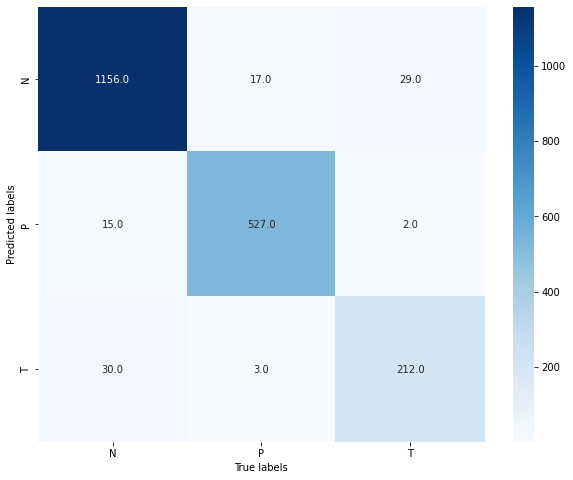

In [88]:
# Print evaluation of model1
count_missclassified_images(y_true, y_predicted1)
compute_AUC(y_true, predictions1)
print_evaluation(y_true, y_predicted1)

Number of missclassified images is 106

AUC:  0.9921
Accuracy: 0.9468
Precision: 0.926
Recall: 0.9248
F1 score class N: 0.9586
F1 score class P: 0.9619
F1 score class T: 0.8554
F1: 0.9253


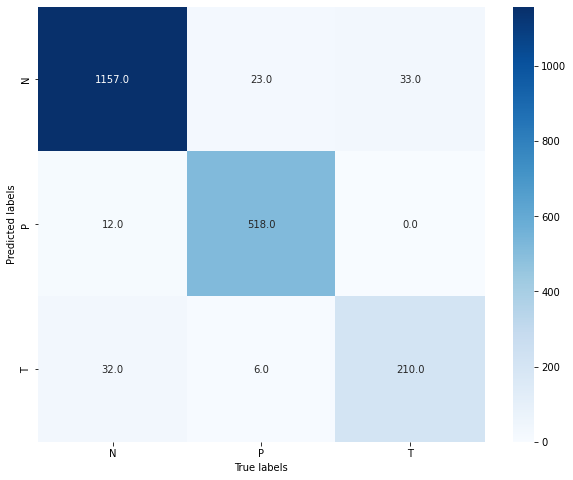

In [66]:
# Print evaluation of model2
count_missclassified_images(y_true, y_predicted2)
compute_AUC(y_true, predictions2)
print_evaluation(y_true, y_predicted2)

Number of missclassified images is 190

AUC:  0.9654
Accuracy: 0.9046
Precision: 0.8574
Recall: 0.8924
F1 score class N: 0.922
F1 score class P: 0.9383
F1 score class T: 0.758
F1: 0.8728


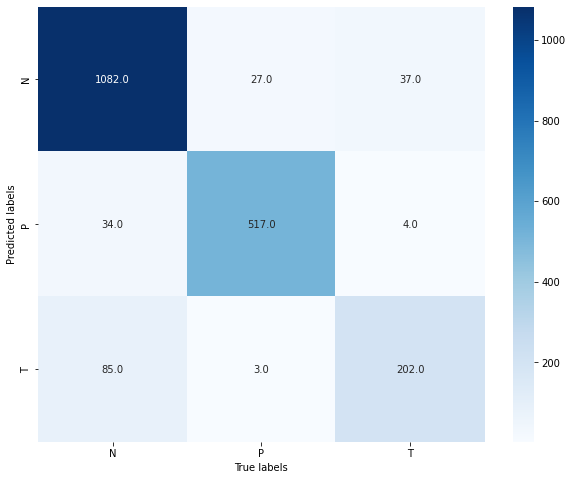

In [67]:
# Print evaluation of model3
count_missclassified_images(y_true, y_predicted3)
compute_AUC(y_true, predictions3)
print_evaluation(y_true, y_predicted3)

In [49]:
def confidence_evaluation(predictions, y_true, confidence=0.33):
  """
  This method receives the predictions(probabilities) of the models and 
    it computes the evaluation metrics using only the prediction
    where the max probabilities is above a confidence threshold.
  """
  # List that will contain only the prediction with a certain confidence
  confident_predictions = []
  # List that will contain the true labels corresponding to the selected predictions
  confident_y_true = []

  # Count how many predicions are not confident
  count_non_confident = 0

  for i, prediction in enumerate(predictions):
    # If the max probability > confidence
    if np.max(prediction, axis=-1) > confidence:
      confident_predictions.append(prediction)
      confident_y_true.append(y_true[i])
    else:
      # Increase the counter
      count_non_confident += 1

  # Conver the list into an array
  confident_predictions = np.array(confident_predictions)
  # Get the predicted classes
  confident_y_predicted = np.argmax(confident_predictions, axis=-1)

  print("The number of discarded predictions is {}({:.2f}%)".format(count_non_confident, count_non_confident*100/predictions.shape[0]))

  # Define the labels
  class_labels = np.array(["N", "P", "T"])

  class_index = np.array([0, 1, 2])

  AUC = roc_auc_score(confident_y_true, confident_predictions, multi_class='ovr', labels=class_index)

  # Compute the classification metrics
  accuracy = accuracy_score(confident_y_true, confident_y_predicted)
  precision = precision_score(confident_y_true, confident_y_predicted, average='macro')
  recall = recall_score(confident_y_true, confident_y_predicted, average='macro')
  f1 = f1_score(confident_y_true, confident_y_predicted, average='macro')
  f1_for_class = f1_score(confident_y_true, confident_y_predicted, average=None)
  print('AUC:', AUC.round(4))
  print('Accuracy:',accuracy.round(4))
  print('Precision:',precision.round(4))
  print('Recall:',recall.round(4))
  for i in range(class_labels.shape[0]):
    print("F1 score class {}: {}".format(class_labels[i], f1_for_class[i].round(4)))
  print('F1:',f1.round(4))


In [50]:
# Standard evaluation
confidence_evaluation(predictions1, y_true, confidence=0.33)

The number of discarded predictions is 0(0.00%)
AUC: 0.9925
Accuracy: 0.9518
Precision: 0.9319
Recall: 0.9328
F1 score class N: 0.9621
F1 score class P: 0.9661
F1 score class T: 0.8689
F1: 0.9324


In [51]:
# Evaluation with a confidence of 0.5 
confidence_evaluation(predictions1, y_true, confidence=0.5)

The number of discarded predictions is 6(0.30%)
AUC: 0.9926
Accuracy: 0.9537
Precision: 0.9356
Recall: 0.9346
F1 score class N: 0.9629
F1 score class P: 0.9687
F1 score class T: 0.8737
F1: 0.9351


In [52]:
# Evaluation with a confidence of 0.8
confidence_evaluation(predictions1, y_true, confidence=0.8)

The number of discarded predictions is 179(8.99%)
AUC: 0.9963
Accuracy: 0.9796
Precision: 0.9789
Recall: 0.9663
F1 score class N: 0.9832
F1 score class P: 0.9825
F1 score class T: 0.9517
F1: 0.9724


In [53]:
# Evaluation with a confidence of 0.99
confidence_evaluation(predictions1, y_true, confidence=0.99)

The number of discarded predictions is 650(32.65%)
AUC: 0.9992
Accuracy: 0.997
Precision: 0.9983
Recall: 0.9968
F1 score class N: 0.9974
F1 score class P: 0.9952
F1 score class T: 1.0
F1: 0.9975


In [54]:
# Standard evaluation
confidence_evaluation(predictions2, y_true, confidence=0.33)

The number of discarded predictions is 0(0.00%)
AUC: 0.9921
Accuracy: 0.9468
Precision: 0.926
Recall: 0.9248
F1 score class N: 0.9586
F1 score class P: 0.9619
F1 score class T: 0.8554
F1: 0.9253


In [55]:
# Evaluation with a confidence of 0.5 
confidence_evaluation(predictions2, y_true, confidence=0.5)

The number of discarded predictions is 7(0.35%)
AUC: 0.9923
Accuracy: 0.9486
Precision: 0.9288
Recall: 0.9271
F1 score class N: 0.9594
F1 score class P: 0.9653
F1 score class T: 0.8589
F1: 0.9279


In [56]:
# Evaluation with a confidence of 0.8
confidence_evaluation(predictions2, y_true, confidence=0.8)

The number of discarded predictions is 161(8.09%)
AUC: 0.9958
Accuracy: 0.9738
Precision: 0.9595
Recall: 0.9653
F1 score class N: 0.9793
F1 score class P: 0.9814
F1 score class T: 0.9264
F1: 0.9623


In [57]:
# Evaluation with a confidence of 0.99
confidence_evaluation(predictions2, y_true, confidence=0.99)

The number of discarded predictions is 658(33.05%)
AUC: 0.9992
Accuracy: 0.9985
Precision: 0.9991
Recall: 0.9969
F1 score class N: 0.9987
F1 score class P: 0.9988
F1 score class T: 0.9966
F1: 0.998


In [58]:
# Standard evaluation
confidence_evaluation(predictions3, y_true, confidence=0.33)

The number of discarded predictions is 0(0.00%)
AUC: 0.9654
Accuracy: 0.9046
Precision: 0.8574
Recall: 0.8924
F1 score class N: 0.922
F1 score class P: 0.9383
F1 score class T: 0.758
F1: 0.8728


In [59]:
# Evaluation with a confidence of 0.5 
confidence_evaluation(predictions3, y_true, confidence=0.5)

The number of discarded predictions is 11(0.55%)
AUC: 0.9658
Accuracy: 0.9066
Precision: 0.8594
Recall: 0.8953
F1 score class N: 0.9234
F1 score class P: 0.9399
F1 score class T: 0.7619
F1: 0.8751


In [60]:
# Evaluation with a confidence of 0.8
confidence_evaluation(predictions3, y_true, confidence=0.8)

The number of discarded predictions is 209(10.50%)
AUC: 0.9703
Accuracy: 0.9478
Precision: 0.9215
Recall: 0.9337
F1 score class N: 0.9559
F1 score class P: 0.9672
F1 score class T: 0.8592
F1: 0.9274


In [61]:
# Evaluation with a confidence of 0.99
confidence_evaluation(predictions3, y_true, confidence=0.99)

The number of discarded predictions is 644(32.35%)
AUC: 0.9742
Accuracy: 0.9733
Precision: 0.967
Recall: 0.9554
F1 score class N: 0.9763
F1 score class P: 0.9862
F1 score class T: 0.9205
F1: 0.961


## Classic ensamble
Average the probabilities between the three models

In [62]:
total_predictions = (predictions1 + predictions2 + predictions3) / 3
y_total_predicted = tf.argmax(total_predictions, axis=-1)

Number of missclassified images is 73

AUC:  0.994
Accuracy: 0.9633
Precision: 0.9464
Recall: 0.947
F1 score class N: 0.9709
F1 score class P: 0.9798
F1 score class T: 0.8893
F1: 0.9467


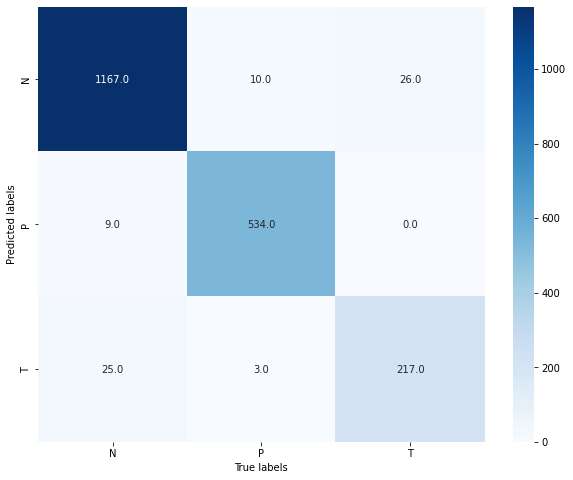

In [68]:
# Print evaluation of the average ensamble
count_missclassified_images(y_true, y_total_predicted)
compute_AUC(y_true, total_predictions)
print_evaluation(y_true, y_total_predicted)

In [69]:
# Evaluation with a confidence of 0.9
confidence_evaluation(total_predictions, y_true, confidence=0.9)

The number of discarded predictions is 437(21.95%)
AUC: 0.9988
Accuracy: 0.9949
Precision: 0.9947
Recall: 0.9899
F1 score class N: 0.9957
F1 score class P: 0.9967
F1 score class T: 0.9843
F1: 0.9923


In [70]:
# Evaluation with a confidence of 0.9
confidence_evaluation(total_predictions, y_true, confidence=0.99)

The number of discarded predictions is 872(43.80%)
AUC: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score class N: 1.0
F1 score class P: 1.0
F1 score class T: 1.0
F1: 1.0


## Pipeline ensamble
Create a pipeline with the model considering only the prediction with high confidence

In [71]:
confidence_value = 0.90
count_of_miss = 0
# Create a mask for the prediction where the confidence threshold is satisfied
confidence_mask_1 = [True if np.max(prediction) >= confidence_value else False for prediction in predictions1]
y_predictions_confidence_1 = tf.argmax(predictions1[confidence_mask_1], axis=-1)
y_confidence_1 = y_true[confidence_mask_1]

assert y_predictions_confidence_1.shape[0] == y_confidence_1.shape[0]

print("Predicted {} over {}".format(y_predictions_confidence_1.shape[0], predictions1.shape[0]))

Predicted 1721 over 1991


Number of missclassified images is 19
Accuracy: 0.989
Precision: 0.991
Recall: 0.9812
F1 score class N: 0.9909
F1 score class P: 0.9889
F1 score class T: 0.9781
F1: 0.986


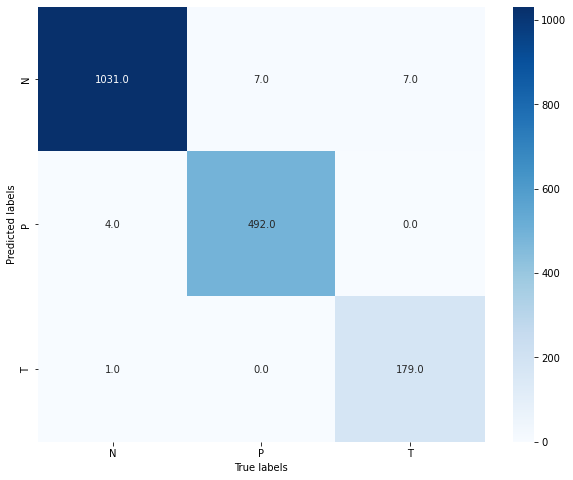

In [72]:
# Print evaluation of the first model over the selected values
count_of_miss += count_missclassified_images(y_confidence_1, y_predictions_confidence_1)
print_evaluation(y_confidence_1, y_predictions_confidence_1)

In [73]:
# Get the mask only of the images still to classify
to_predict_mask = np.logical_not(confidence_mask_1)

print("Still {} have to be classified".format(sum(to_predict_mask)))

Still 270 have to be classified


In [74]:
reduced_predictions_2 = predictions2[to_predict_mask]
reduced_y_true = y_true[to_predict_mask]

assert reduced_predictions_2.shape[0] == reduced_y_true.shape[0]

In [75]:
# Now let's classify the remaining images using the second model

# Create a mask for the prediction where the confidence threshold is satisfied
confidence_mask_2 = [True if np.max(prediction) >= confidence_value else False for prediction in reduced_predictions_2]
y_predictions_confidence_2 = tf.argmax(reduced_predictions_2[confidence_mask_2], axis=-1)
y_confidence_2 = reduced_y_true[confidence_mask_2]

assert y_predictions_confidence_2.shape[0] == y_confidence_2.shape[0]

print("Predicted {} over {}".format(y_predictions_confidence_2.shape[0], reduced_predictions_2.shape[0]))

Predicted 93 over 270


Number of missclassified images is 17
Accuracy: 0.8172
Precision: 0.7888
Recall: 0.8188
F1 score class N: 0.8522
F1 score class P: 0.8125
F1 score class T: 0.7179
F1: 0.7942


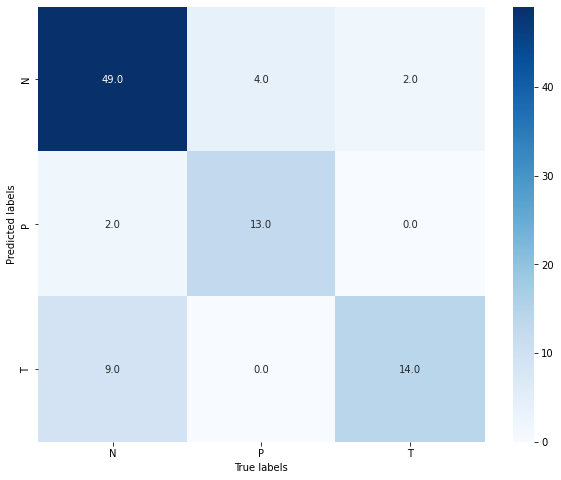

In [77]:
# Print evaluation of the first model over the selected values
count_of_miss += count_missclassified_images(y_confidence_2, y_predictions_confidence_2)
print_evaluation(y_confidence_2, y_predictions_confidence_2)

There are 2 options now
- or we classify the remaining images with the third model
- or we classify the remaining images using the ensamble model

In [78]:
# Let's classify the remaining images using the ensamble model

In [79]:
# Take mask1, update it with the mask2 and get the overall mask over all the data
confidence_mask_final = confidence_mask_1.copy()

j = 0
for i in range(len(confidence_mask_final)):
  # Update the value of the mask using the second mask
  if confidence_mask_final[i] == False:
    confidence_mask_final[i] = confidence_mask_2[j]
    # Increment j to go to the next element of mask2
    j += 1

In [80]:
# Get the mask only of the images still to classify
to_predict_mask = np.logical_not(confidence_mask_final)

print("Still {} have to be classified".format(sum(to_predict_mask)))

Still 177 have to be classified


In [81]:
reduced_predictions_ensamble = total_predictions[to_predict_mask]
reduced_y_true = y_true[to_predict_mask]

assert reduced_predictions_ensamble.shape[0] == reduced_y_true.shape[0]

In [82]:
# Now let's classify the remaining images using the ensamble model

# Create a mask for the prediction where the confidence threshold is satisfied
# confidence_mask_ensamble = [True if np.max(prediction) >= confidence_value else False for prediction in reduced_predictions_ensamble]
y_predictions_confidence_ensamble = tf.argmax(reduced_predictions_ensamble, axis=-1)
y_confidence_ensamble = reduced_y_true

assert y_predictions_confidence_ensamble.shape[0] == y_confidence_ensamble.shape[0]

print("Predicted {} over {}".format(y_predictions_confidence_ensamble.shape[0], reduced_predictions_ensamble.shape[0]))

Predicted 177 over 177


Number of missclassified images is 39
Accuracy: 0.7797
Precision: 0.7677
Recall: 0.7666
F1 score class N: 0.8269
F1 score class P: 0.8852
F1 score class T: 0.5882
F1: 0.7668


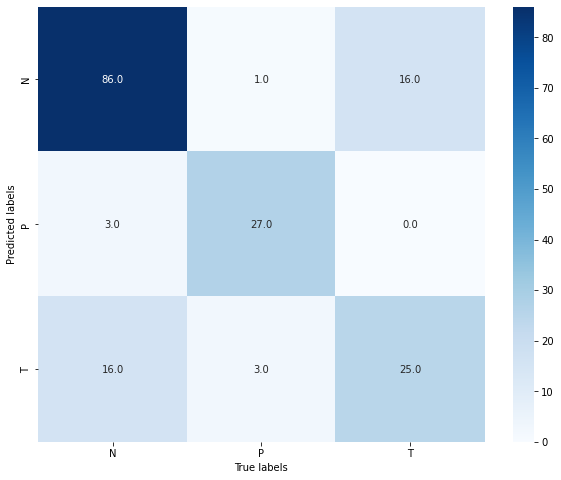

In [83]:
# Print evaluation of the first model over the selected values
count_of_miss += count_missclassified_images(y_confidence_ensamble, y_predictions_confidence_ensamble)
print_evaluation(y_confidence_ensamble, y_predictions_confidence_ensamble)

In [84]:
print("The total number of misslcassified images is {}".format(count_of_miss))

The total number of misslcassified images is 92
